<a href="https://colab.research.google.com/github/GaneshSai239/sentiment_analysis_of_web_scraped_data/blob/main/Web_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install feedparser

Importing required libraries

In [83]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import feedparser
from transformers import pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import spacy

Web Scraping and feedparseing of the given url

In [84]:
cnbc_url = "https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen"
cnbc_response = requests.get(cnbc_url)
cnbc_soup = BeautifulSoup(cnbc_response.text, "html.parser")
cnbc_headlines = [headline.text.strip() for headline in cnbc_soup.find_all("a", class_="Card-title")]

google_news_url = "https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en"
news_feed = feedparser.parse(google_news_url)
news_headlines = [entry.title for entry in news_feed.entries]
news_dates = [entry.published for entry in news_feed.entries]
all_headlines = cnbc_headlines + news_headlines

sentiment-analysis

In [85]:
sentiment_analyzer = pipeline("sentiment-analysis")
headline_sentiments = [sentiment_analyzer(headline)[0]['label'] for headline in all_headlines]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Finding Organization names using spacy

In [86]:
nlp = spacy.load("en_core_web_sm")

organizations = []

for headline in all_headlines:
  doc = nlp(headline)
  organizations.append([entity.text for entity in doc.ents if entity.label_ == "ORG"])


Making a Dataframe from the extracted data

In [87]:
data = {
    "Date": news_dates,
    "Headline": all_headlines,
    "Sentiment": headline_sentiments,
    "Organization": organizations
}
df = pd.DataFrame(data)

df.to_csv("green_hydrogen_news.csv", index=False)

auth.authenticate_user()

drive_service = build('drive', 'v3')
file_metadata = {'name': 'Green Hydrogen News'}
media = MediaFileUpload('green_hydrogen_news.csv', mimetype='text/csv')
file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
file_id = file.get('id')
print('File ID:', file_id)
df.head()


File ID: 14RaXs9mB6ijbQ8ecHoukIK_ezThX2W05


Date  \
0  Fri, 09 Feb 2024 06:17:12 GMT   
1  Thu, 08 Feb 2024 11:24:20 GMT   
2  Fri, 09 Feb 2024 21:55:30 GMT   
3  Sat, 10 Feb 2024 14:00:02 GMT   
4  Fri, 09 Feb 2024 13:40:44 GMT   

                                            Headline Sentiment  \
0  L&T, Matrix chosen for green hydrogen scheme a...  NEGATIVE   
1  India Awards Tenders for 4.12 Lakh Tonnes of G...  POSITIVE   
2  Karnataka government to facilitate development...  POSITIVE   
3  A scalable photoelectrochemical system for gre...  POSITIVE   
4  IGX, Acme to develop green hydrogen, ammonia m...  NEGATIVE   

                             Organization  
0        [L&T, Jindal India, Mint - Mint]  
1  [India Awards Tenders, Green Hydrogen]  
2                                      []  
3                                      []  
4                [IGX, Acme, Mint - Mint]

plotting a Weekly Trend of Average Sentiment Scores graphe

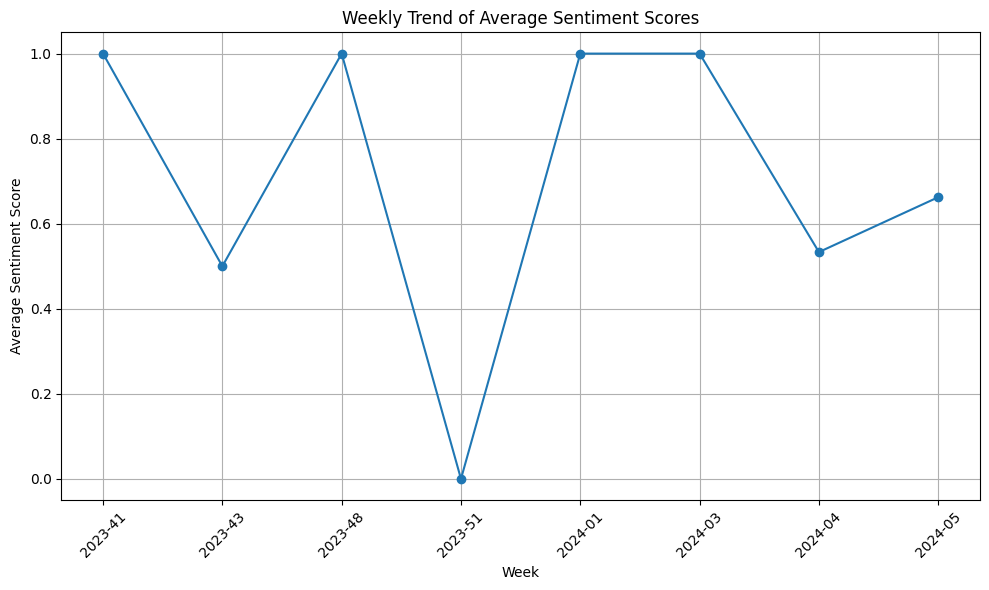

In [88]:
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.strftime('%Y-%U')
weekly_sentiments = df.groupby('Week')['Sentiment'].apply(lambda x: sum(1 for i in x if i == 'POSITIVE') / len(x))
plt.figure(figsize=(10, 6))
weekly_sentiments.plot(kind='line', marker='o')
plt.title('Weekly Trend of Average Sentiment Scores')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Word cloud map with organization name identified in the News headline

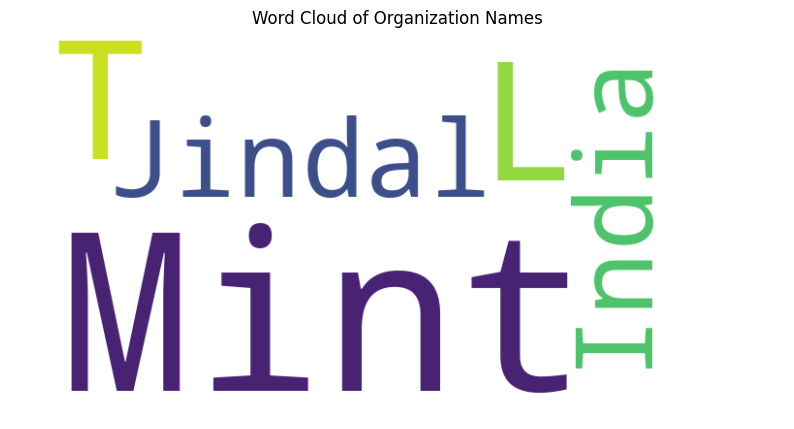

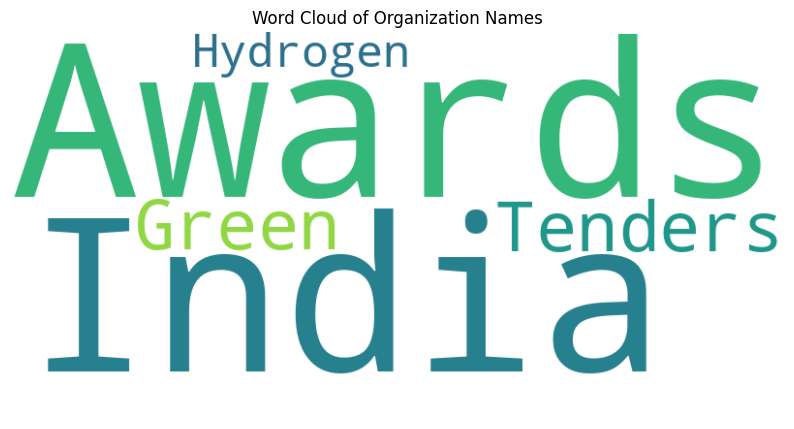

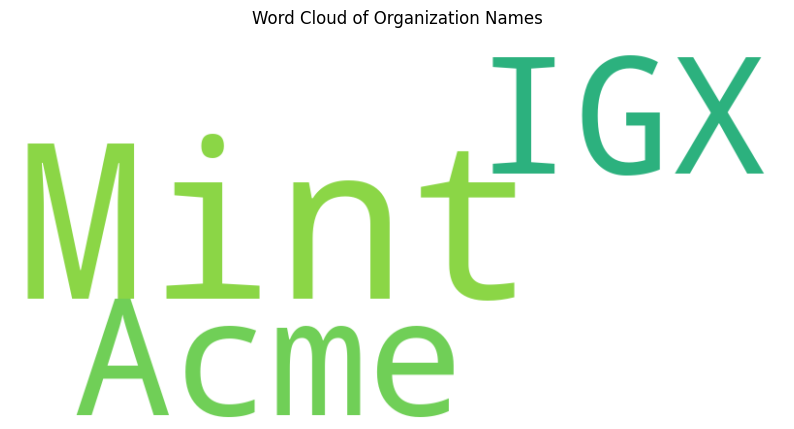

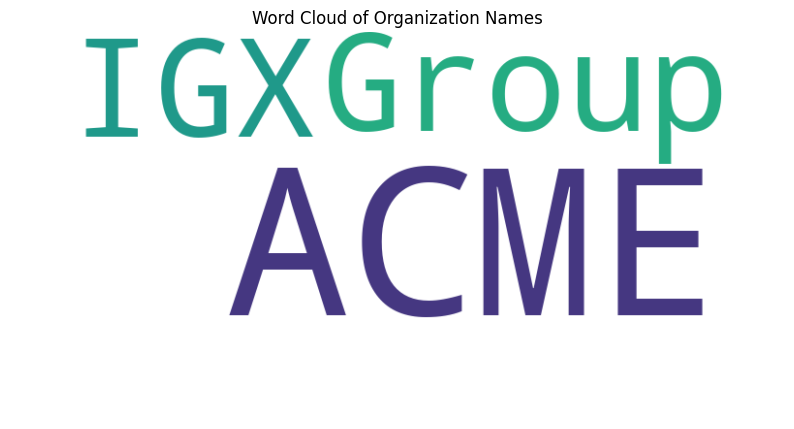

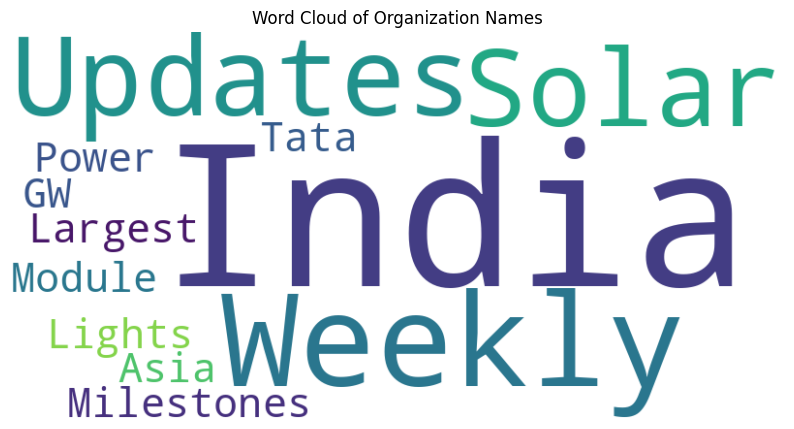

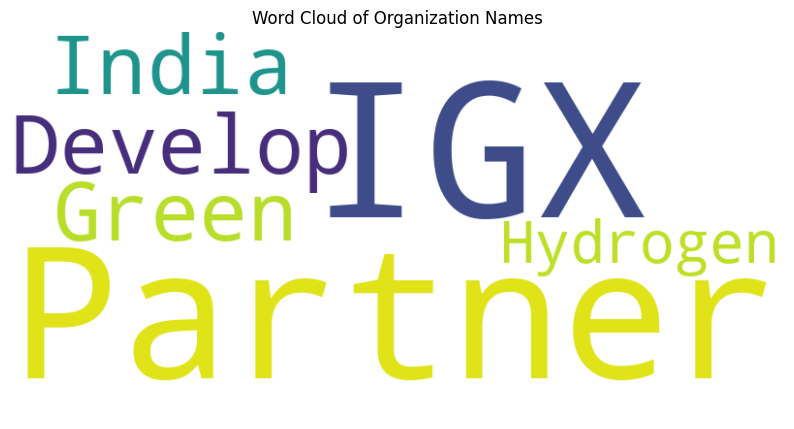

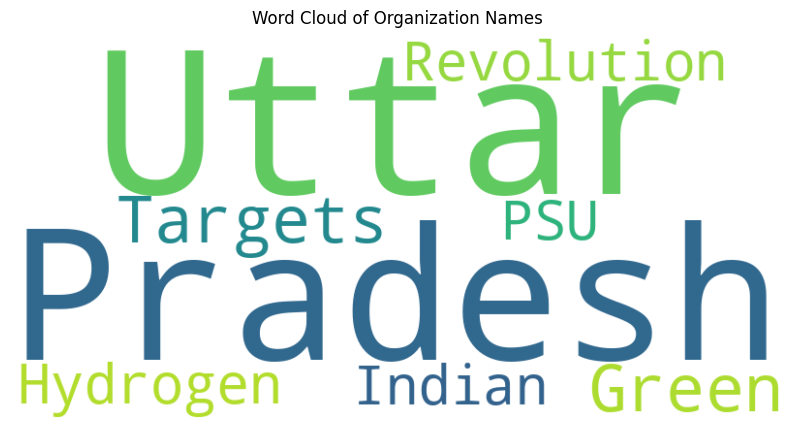

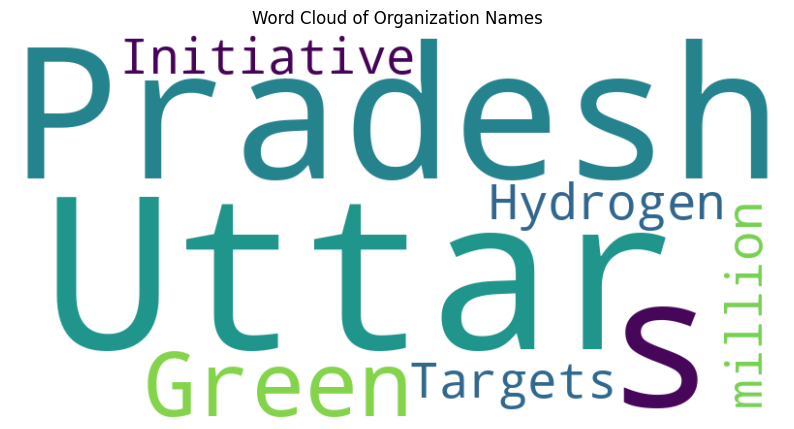

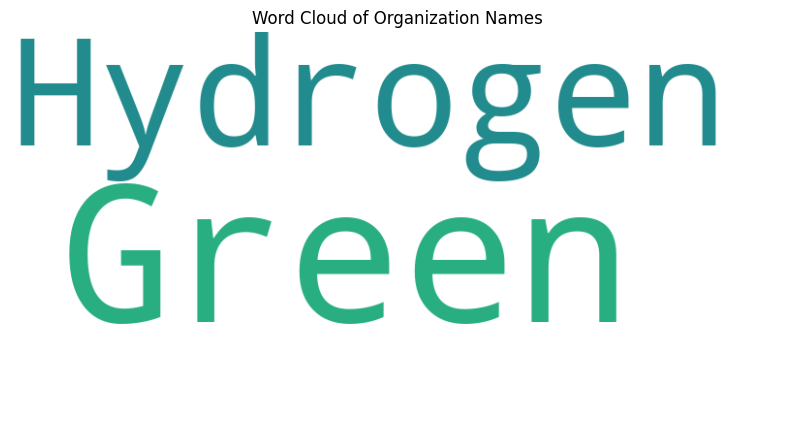

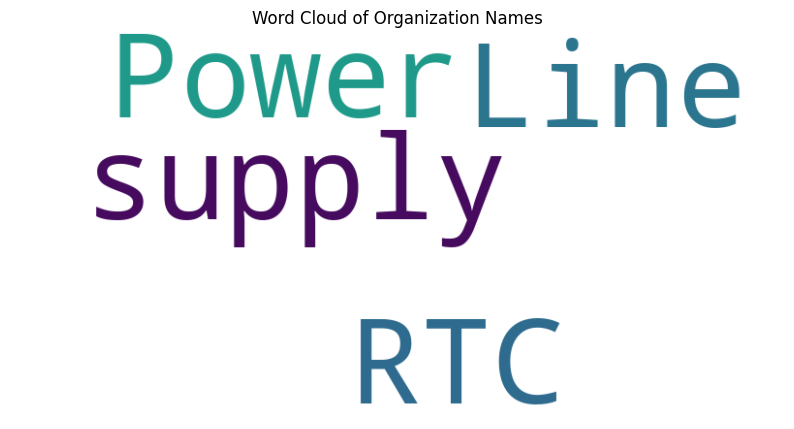

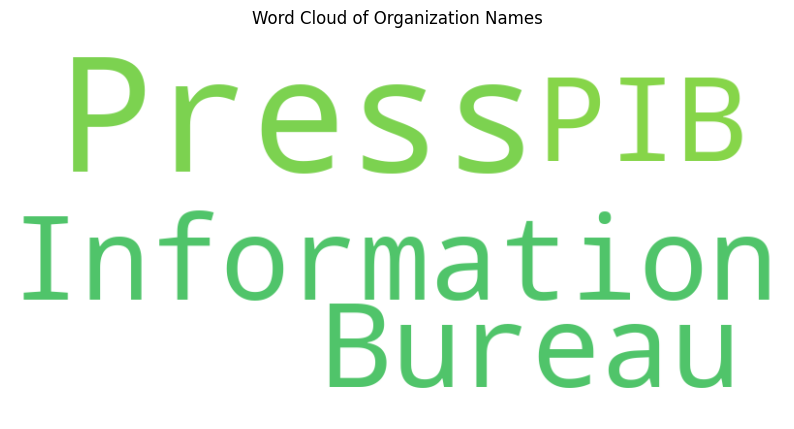

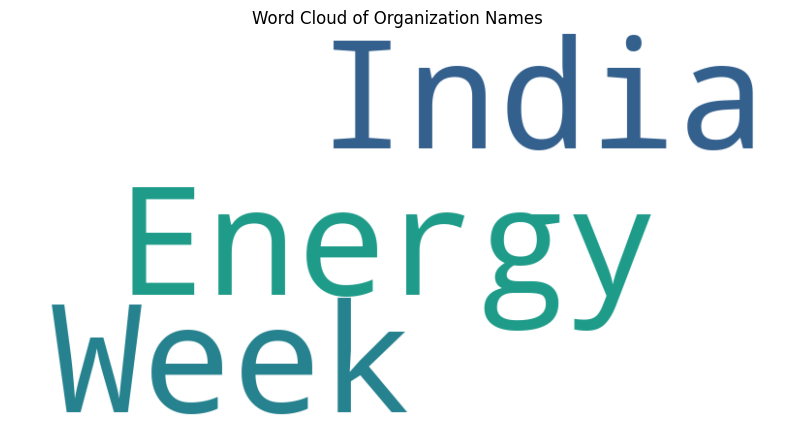

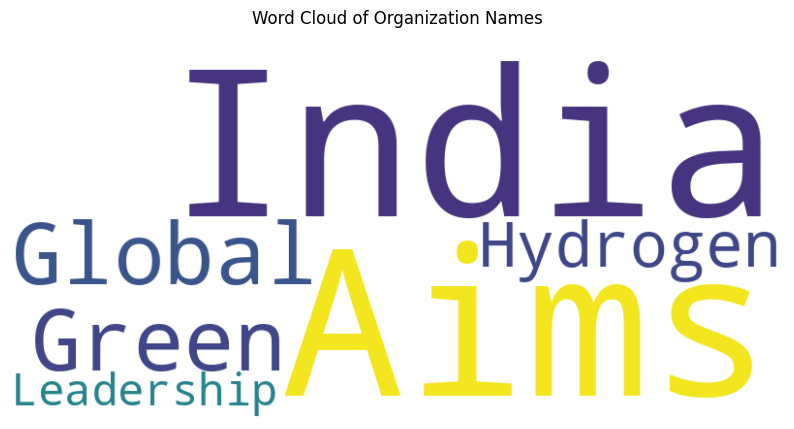

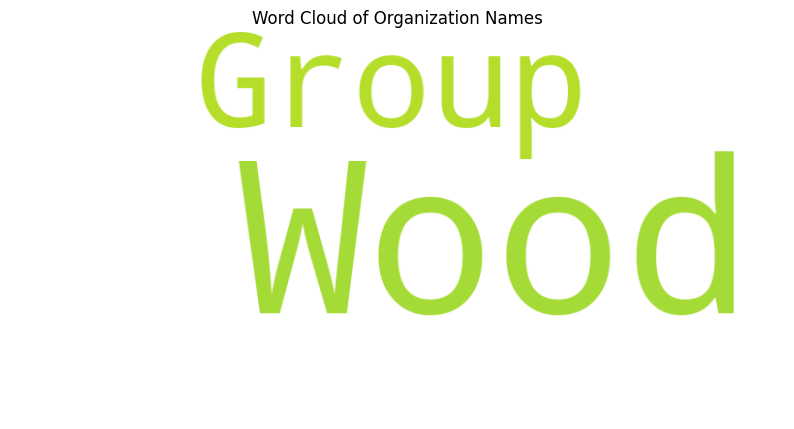

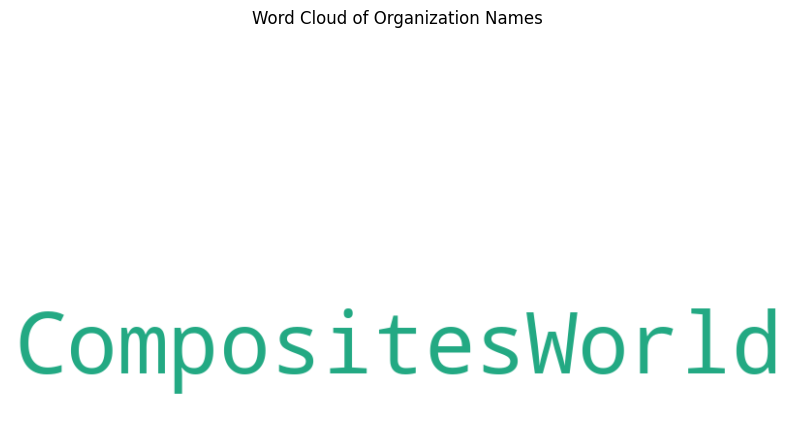

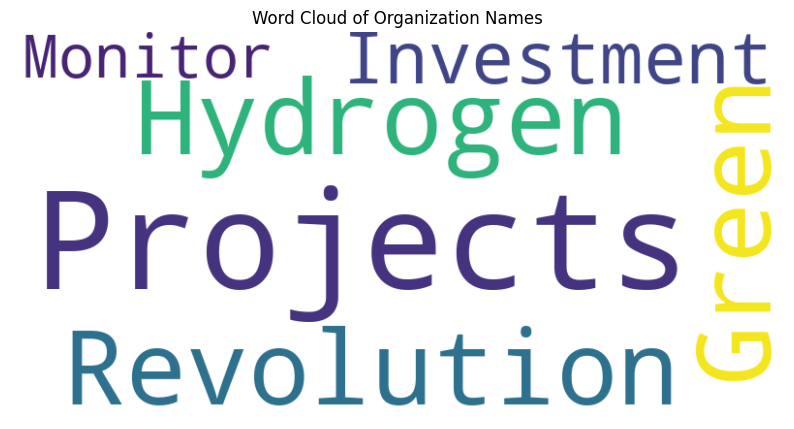

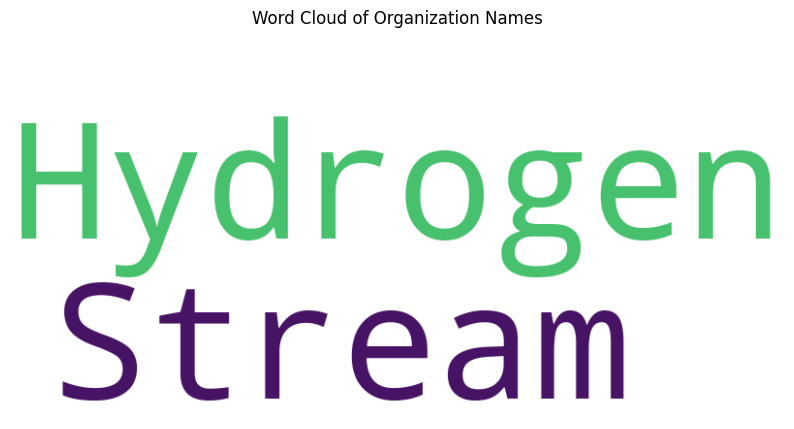

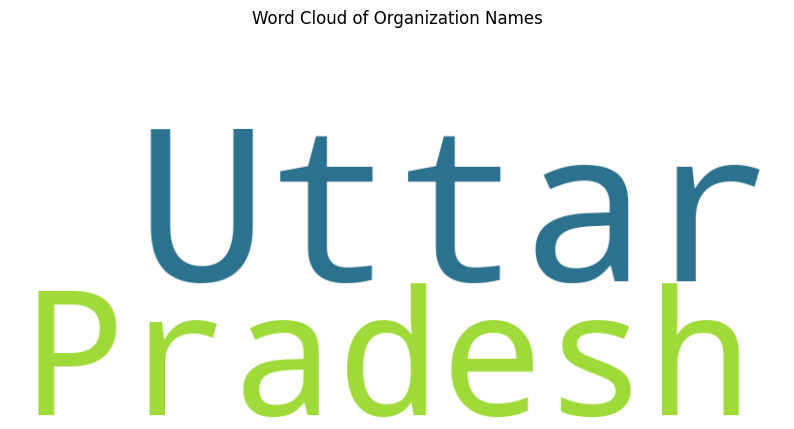

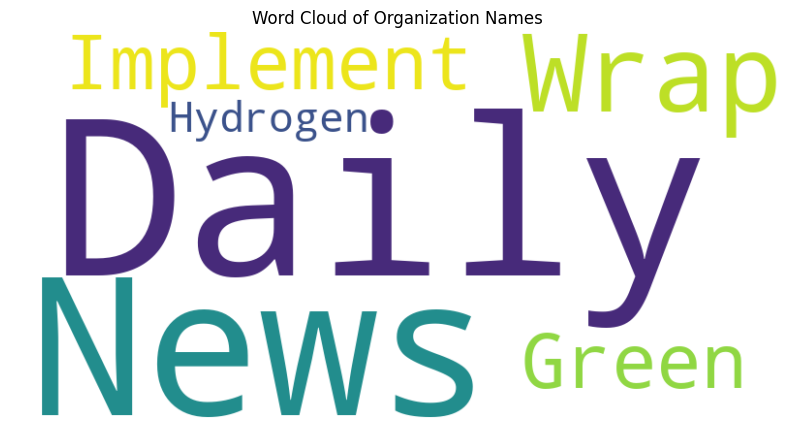

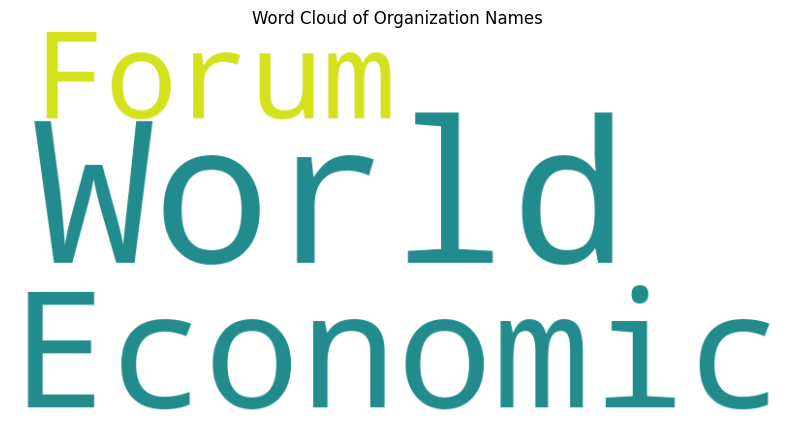

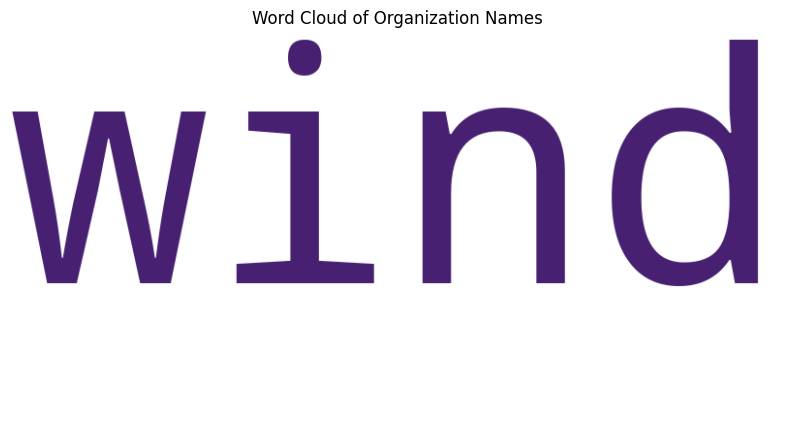

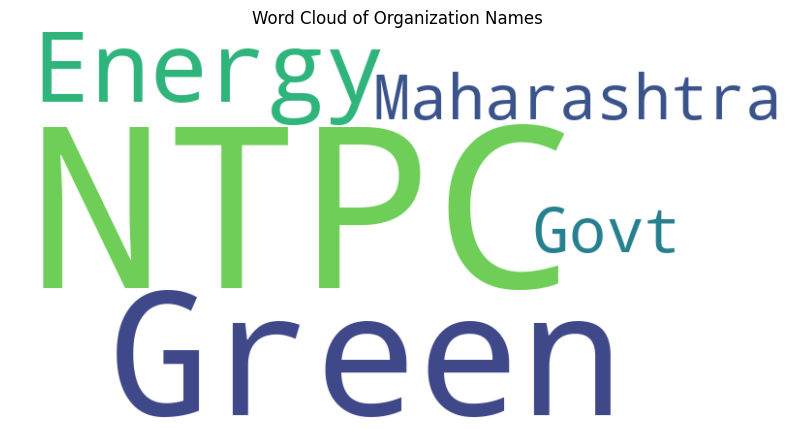

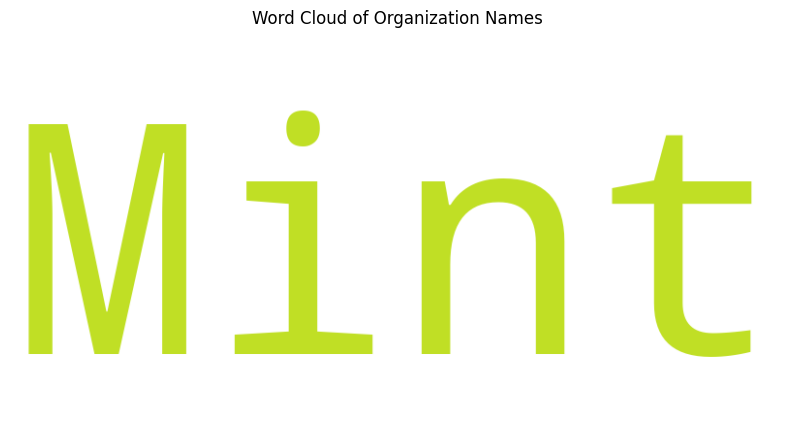

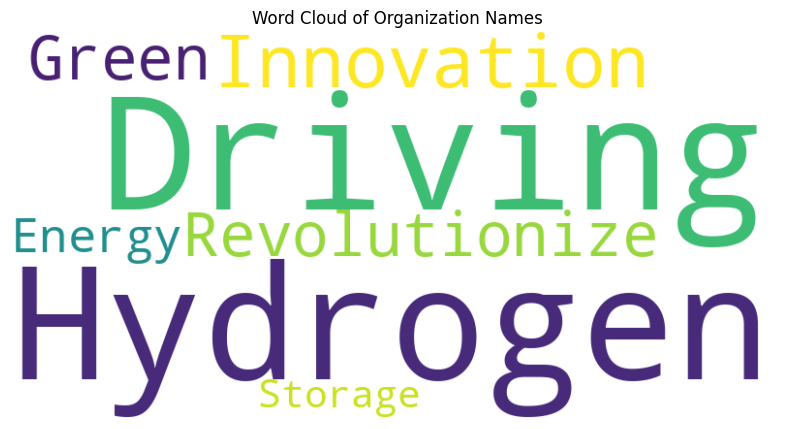

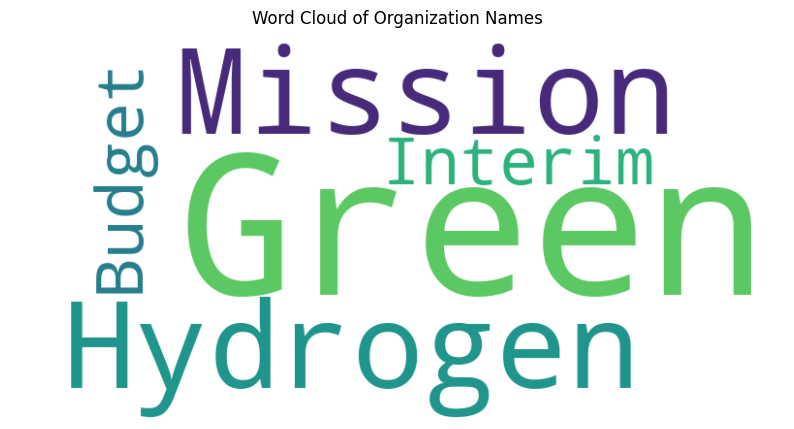

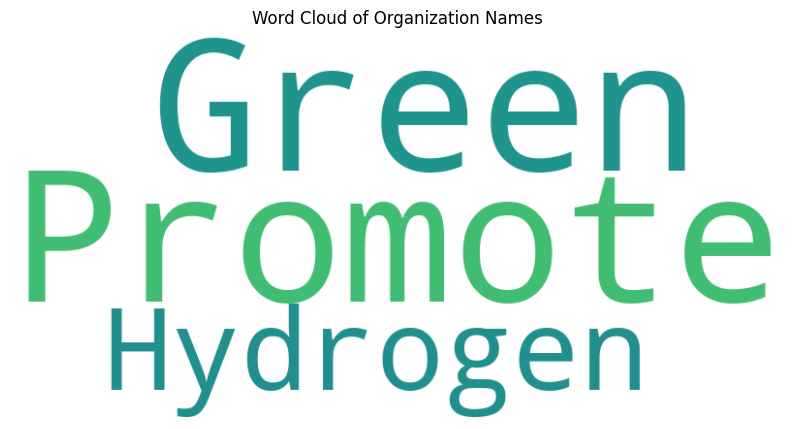

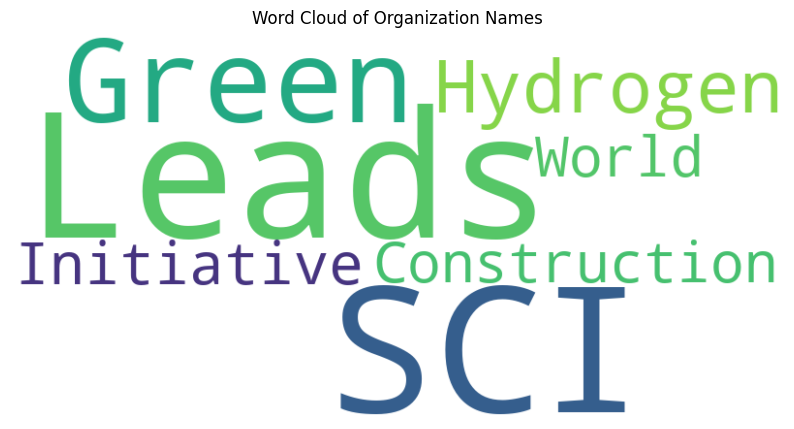

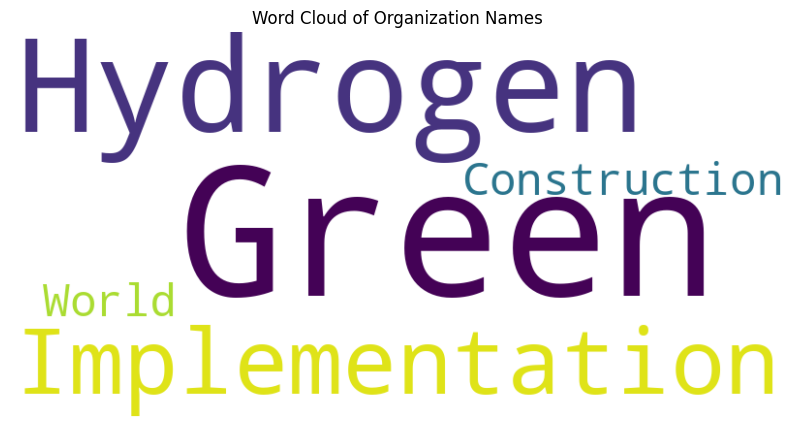

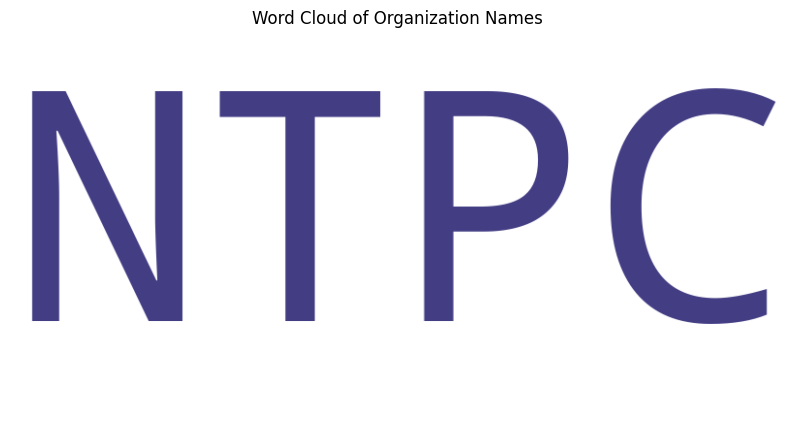

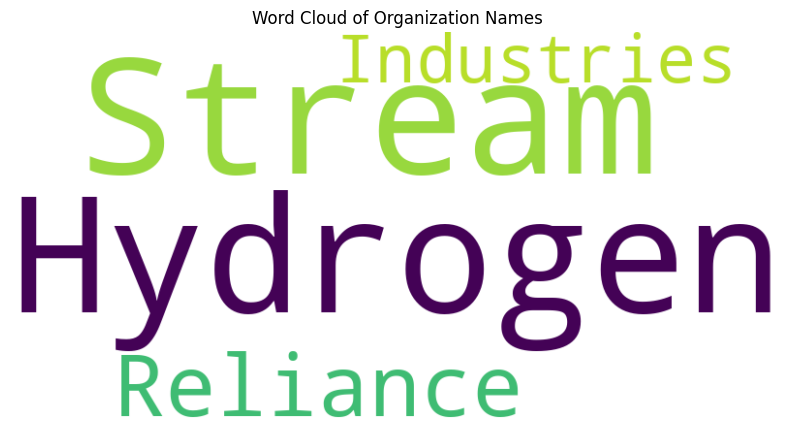

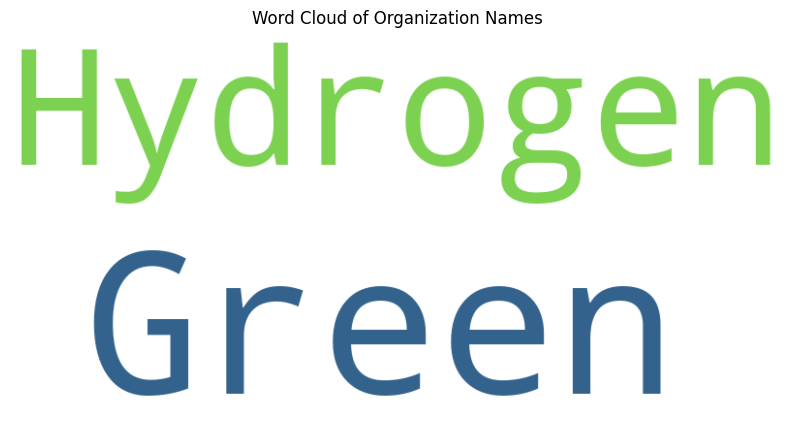

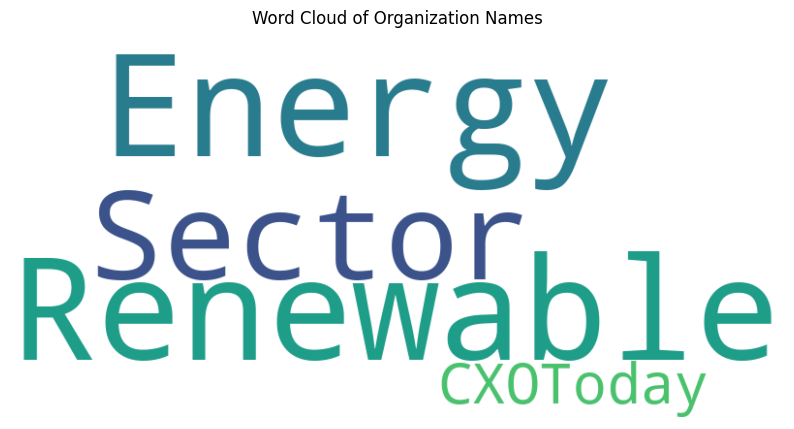

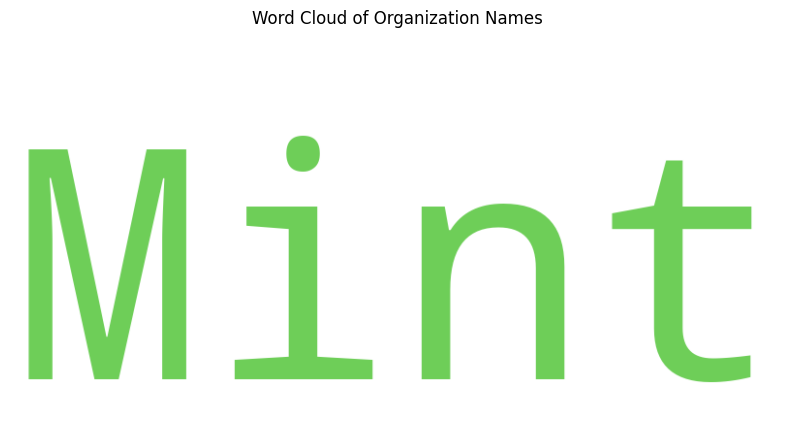

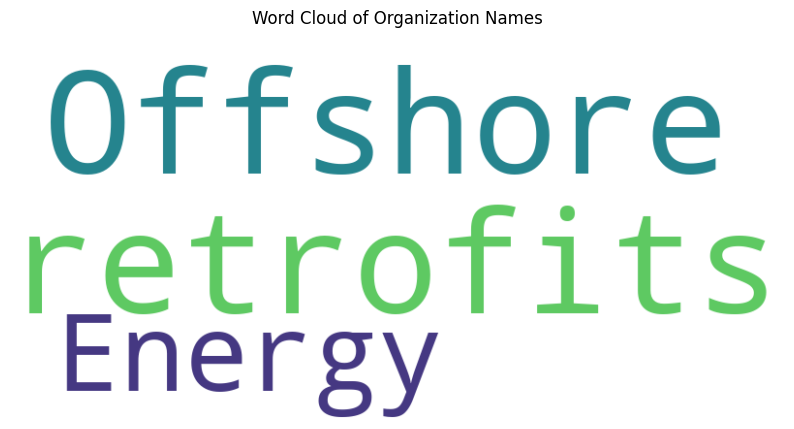

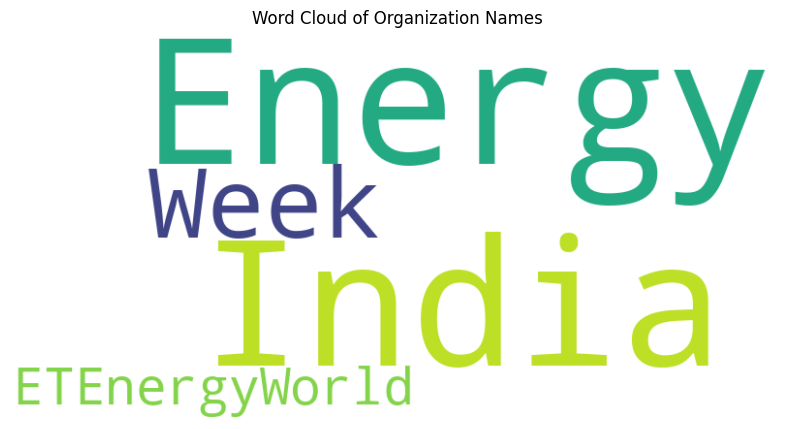

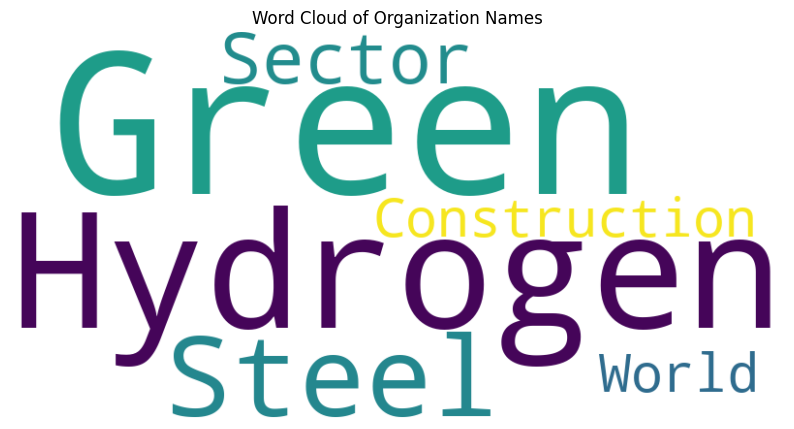

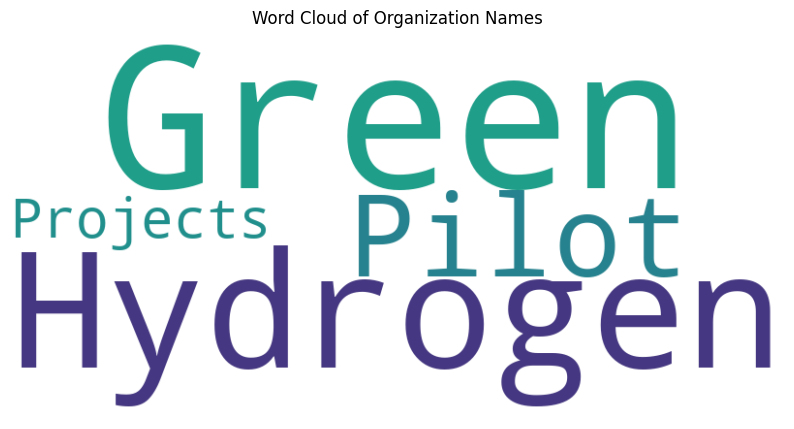

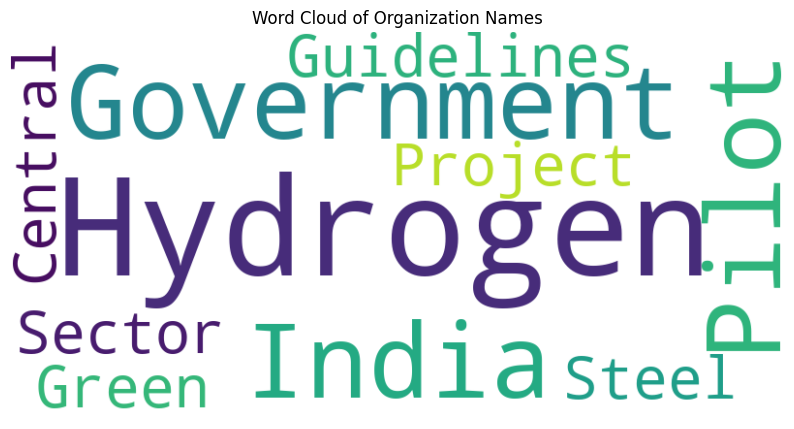

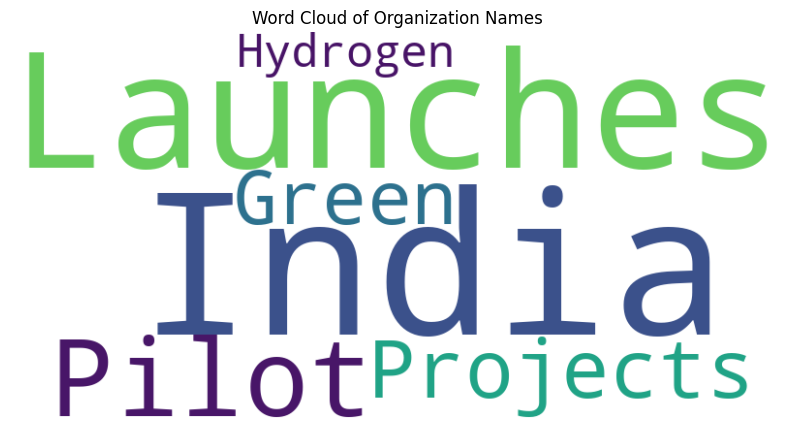

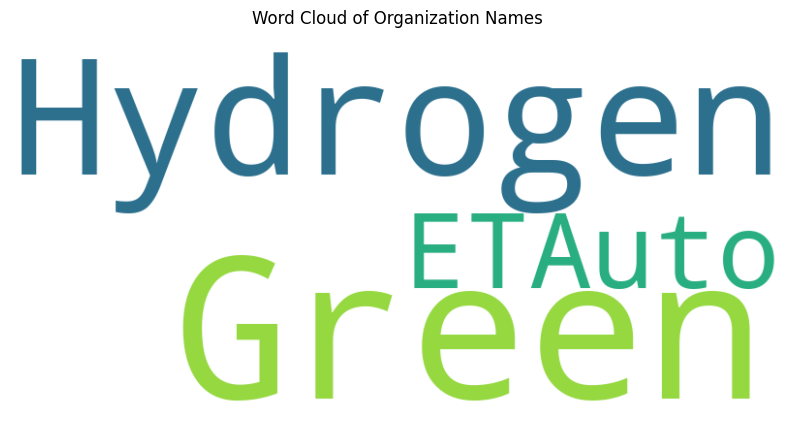

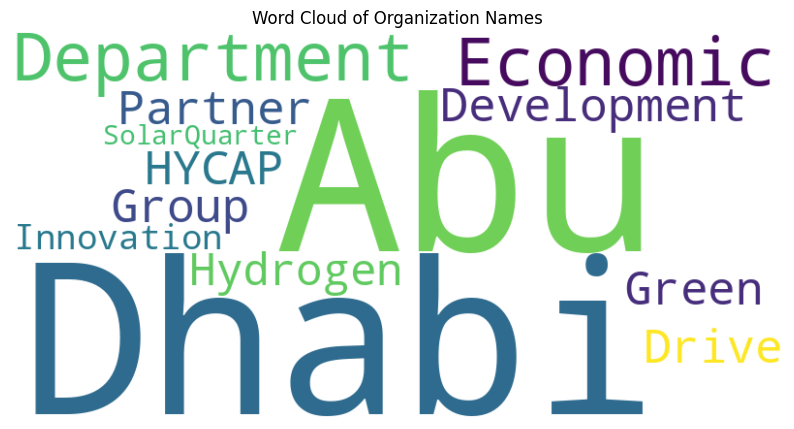

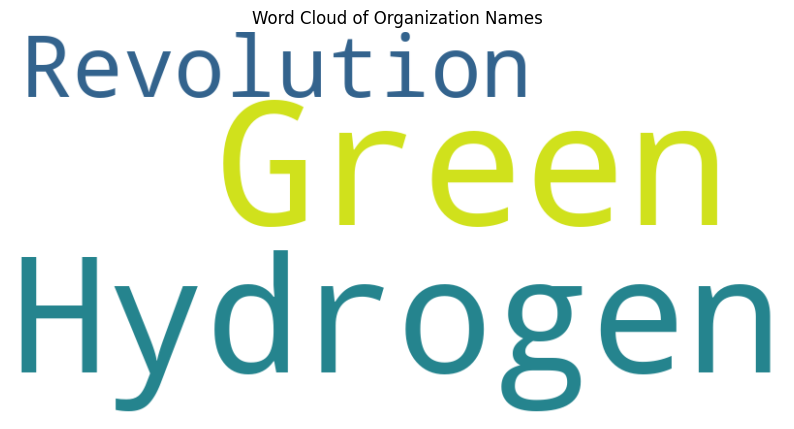

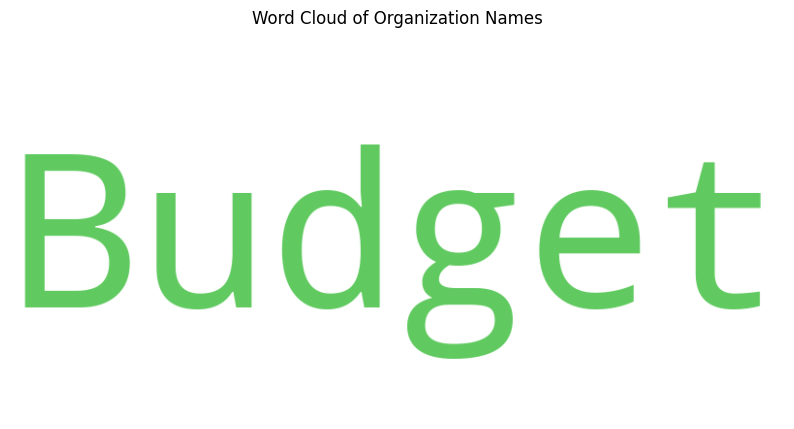

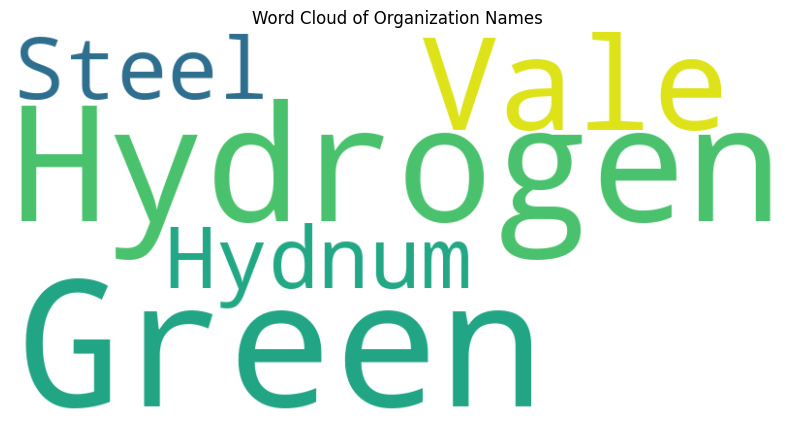

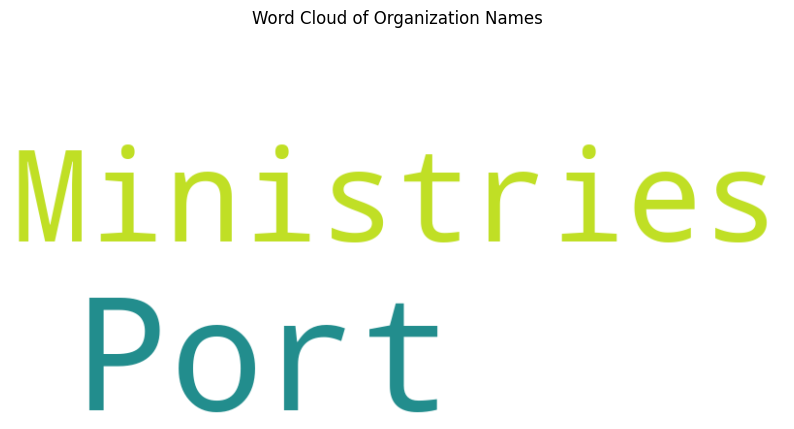

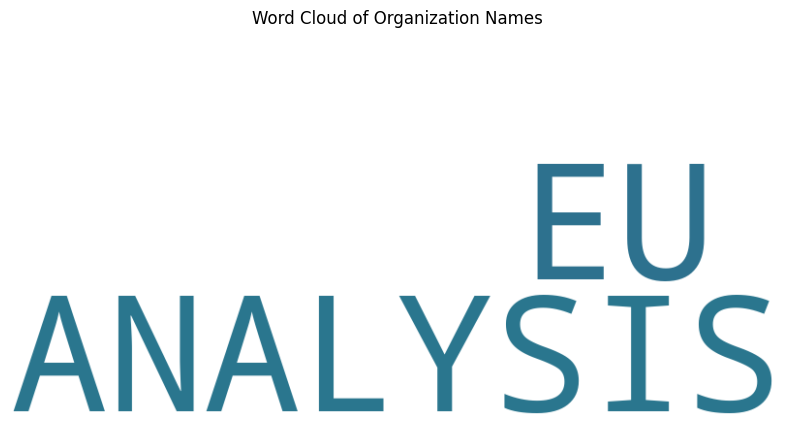

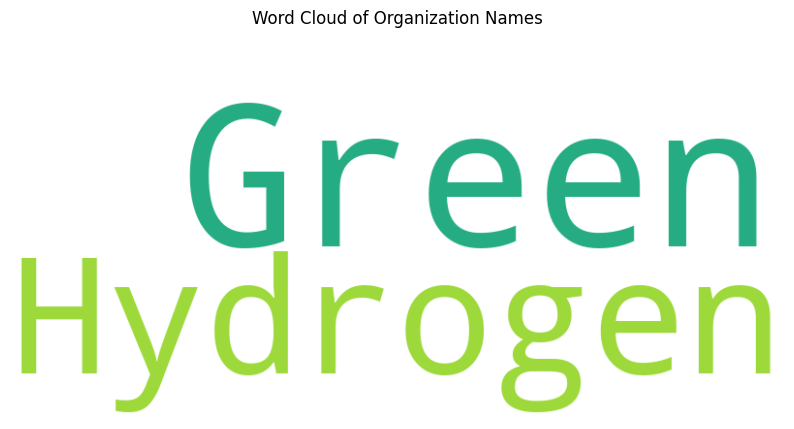

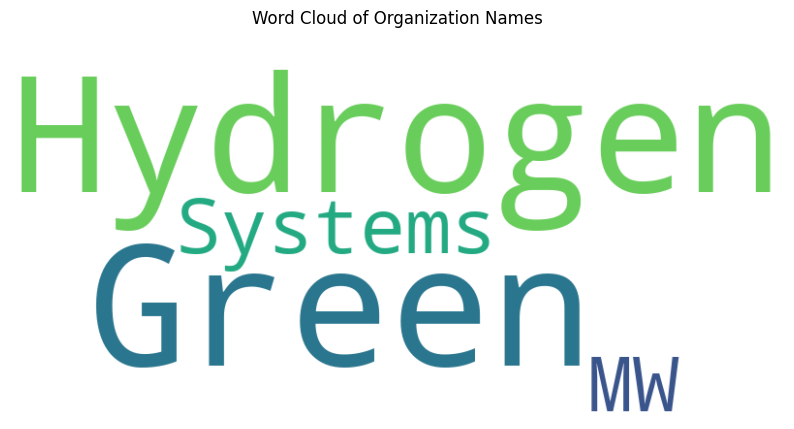

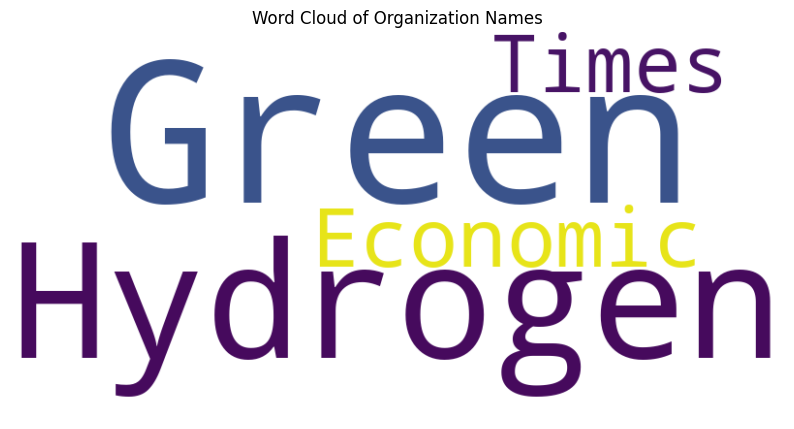

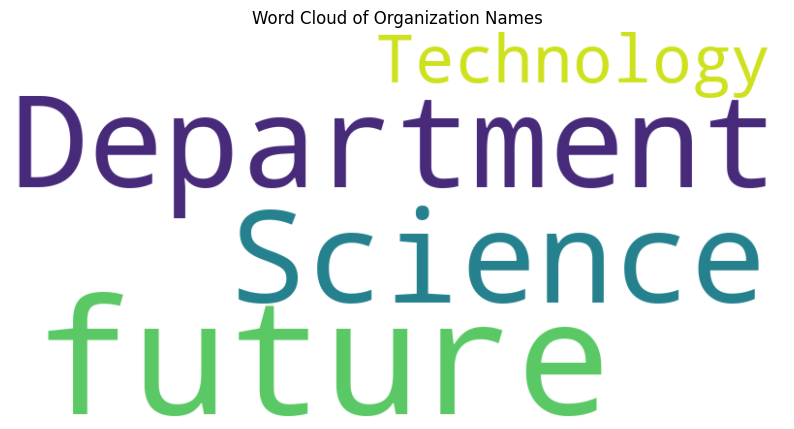

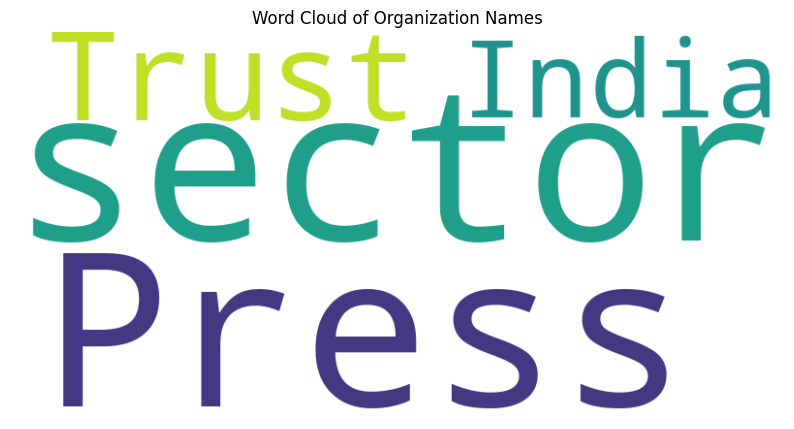

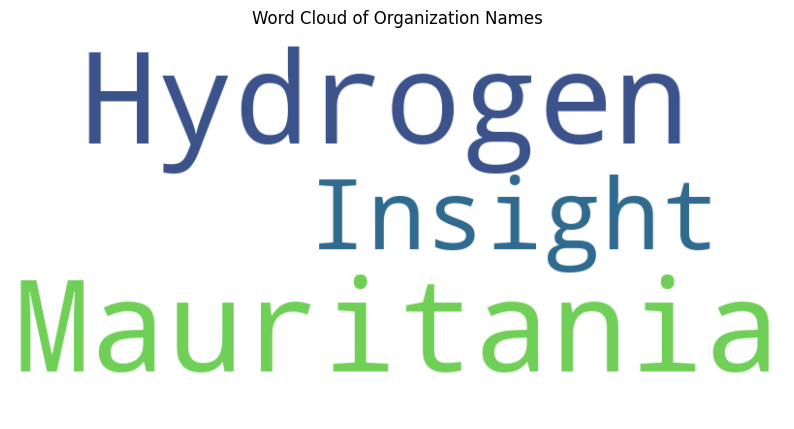

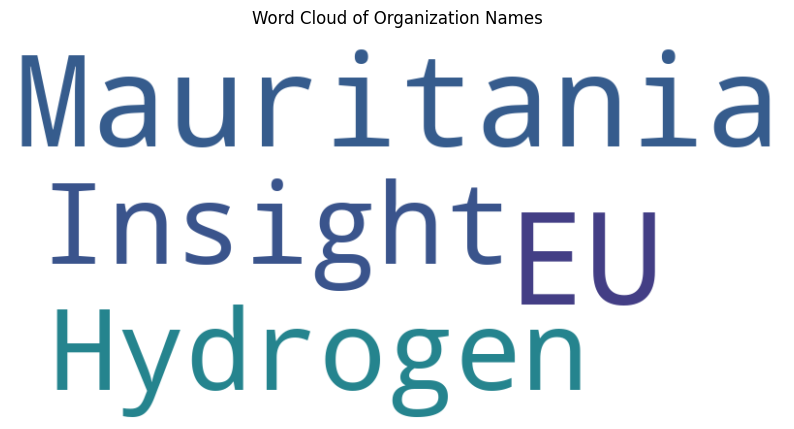

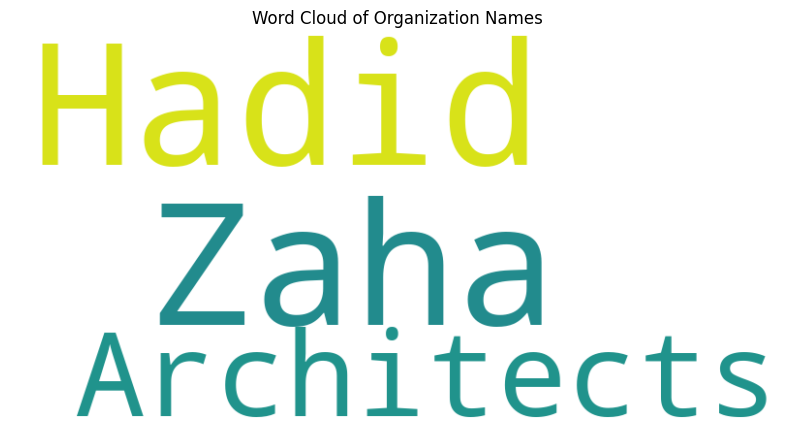

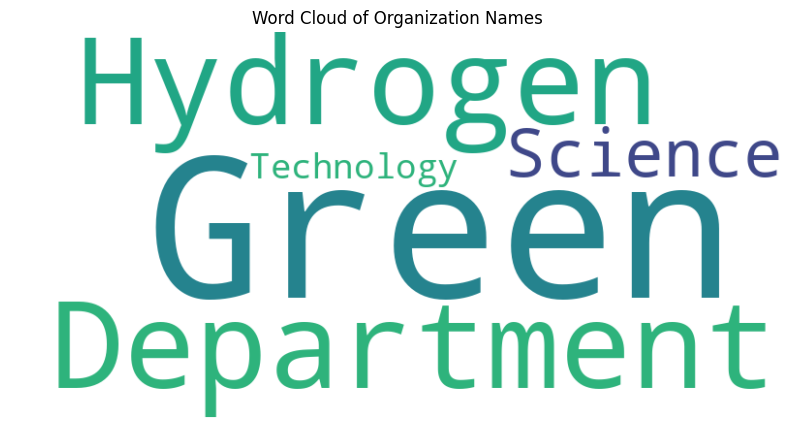

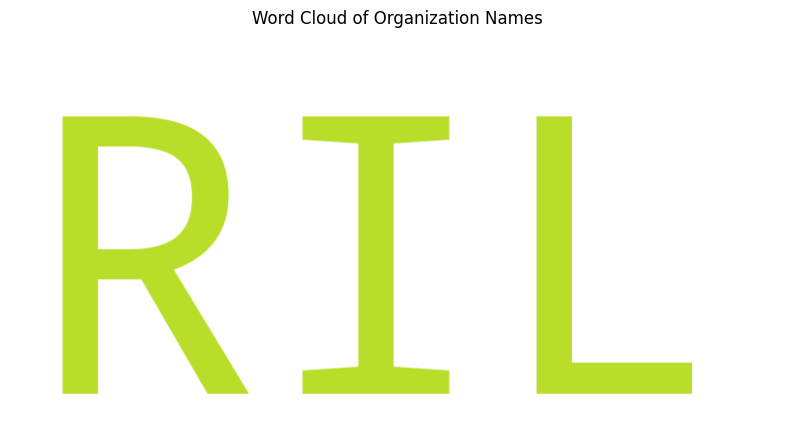

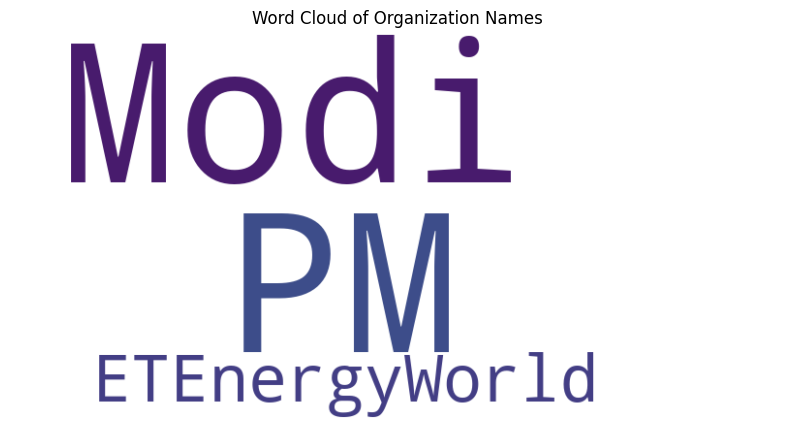

In [90]:
for i in organizations:
  if i != []:
    organization_text = ' '.join(i)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(organization_text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of Organization Names')
    plt.axis('off')
    plt.show()